# Covariance matrix for X

### Assuming $\phi_i = \phi_{i^{\prime}}$ 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy.random
import scipy
from scipy import integrate
from numpy import sin, cos
import pycbc.psd

In [9]:
def covX(dur, tau, dt, fs, N, fmin, fmax, tag):

    #@ Getting total noise PSD S_N
    # Shot noise PSD
    
    freq = np.logspace(-5, 0, 1000)
    w    = 2*np.pi*freq
    
    n1_psd  = n2p_psd = (6e-12)**2
    S_n_shot_x = 2.*(2*n1_psd*(1-cos(2*w*tau)) + (2*n2p_psd)*(1-cos(3*w*tau)))

    # TM-motion PSD
    delta1_psd = delta2p_psd = (2.4e-15)**2
     
    S_n_delta_x  = 2*(2*delta1_psd*(1-cos(4*w*tau)) + 8*delta2p_psd*(1-cos(2*w*tau)))
    S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise


    # DWS noise PSD
    c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
    n_phi1_psd = n_phi1p_psd = n_phi2p_psd = n_phi3_psd = ((35e-9)/300.)**2
    
    S_n_phi_x  = n_phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau))
    S_n_phi_x += n_phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau))
    S_n_phi_x += n_phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS*cos(2*w*tau))
    S_n_phi_x += n_phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS*cos(2*w*tau))
    S_n_phi_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn
    #S_n_phi_x *= 0
    
    # Total noise S_N = shot noise + TM-motion noise + DWS noise
    S_N = S_n_shot_x + S_n_delta_x + S_n_phi_x
    
    ## Integrands
    H_modsq = 2 - 2*cos(2*w*tau)
    
    # DWS signals
    w0 = 2*np.pi*(1e-3)
    w1 = 2*np.pi*(1e-2)
    w2 = 2*np.pi*(1e-1)
    phi1_psd  = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
    phi2p_psd = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
    phi3_psd  = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
    
    '''
    phi1_psd  = ((10e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    phi1p_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    phi2p_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    phi3_psd  = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    '''
    # Old^
    
    # |H|^2 |phi|^2 ~ |H|^2 phi_psd*T
    d11 = integrate_fn(H_modsq*phi1_psd*dur, S_N, w, fmin, fmax)
    d12 = integrate_fn(H_modsq*phi1_psd*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    d55 = integrate_fn(H_modsq*phi2p_psd*dur, S_N, w, fmin, fmax)
    d66 = integrate_fn(H_modsq*phi3_psd*dur, S_N, w, fmin, fmax)
    
    d_vec = d11, d12, d55, d66
    
    cov_x = make_covX_matrix(d_vec) 
    
    if tag == 'plot':
        return np.asarray(cov_x), H_modsq, phi1_psd*dur, S_N, freq
    else: 
        return np.asarray(cov_x)
    
def make_covX_matrix(d_vec):
    
    d11, d12, d55, d66 = d_vec
    
    matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0], [0, 0, 1./d55, 0], [0, 0, 0, 1./d66]]
    return matrix


def integrate_fn(numerator, S_N, w, wmin, wmax):

    integrand = numerator/S_N
    
    # Set limits and resize arrays before integral
    w_max_idx = find_nearest(w, wmax)
    w = w[:w_max_idx+1] # +1 to include the index with value closest to wmax
    
    w_min_idx = find_nearest(w, wmin)
    w = w[w_min_idx:]
    
    integrand = integrand[w_min_idx:w_max_idx+1]
    result = integrate.simps(integrand, x=w, axis=-1, even='avg')

    return result

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [10]:
fs  = 8.
dt  = 1./fs
tau = 2.5e9/3e8
dur = 1*24*3600 # 1 day
#dur = 15*60 # 15 mins
t   = np.arange(0, dur, dt)
N   = len(t)
wmin = 2*np.pi*1./dur
wmax = 2*np.pi*4e-2

print 'Integration limits: ', wmin, wmax

Integration limits:  7.27220521664e-05 0.251327412287


In [11]:
covX_matrix, H_modsq, phi1_modsq, S_N, freq = covX(dur, tau, dt, fs, N, wmin, wmax, 'plot')

print '\n'
print('\n'.join([' '.join(['{:4}'.format(item) for item in row]) 
      for row in covX_matrix]))



2.4615093732e-10 1.69384881245e-10  0.0  0.0
1.69384881245e-10 2.4615093732e-10  0.0  0.0
 0.0  0.0 1.29591405568e-10  0.0
 0.0  0.0  0.0 1.29591405568e-10


/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in divide


/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


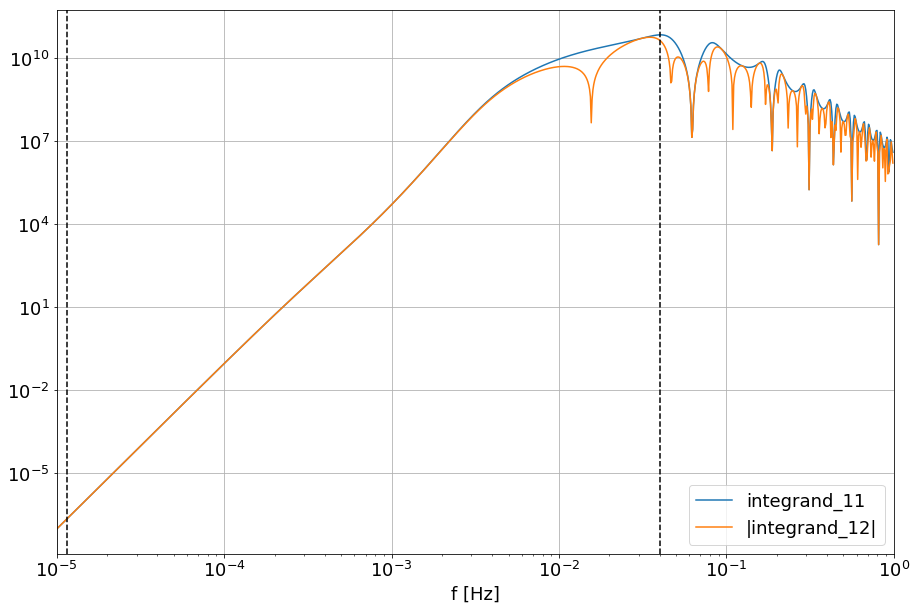

In [12]:
# Checking frequency dependence of integrands

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, H_modsq*phi1_modsq/S_N, label='integrand_11')
plt.loglog(freq, np.abs(H_modsq*phi1_modsq*cos(2*2*np.pi*freq*tau)/S_N), label='|integrand_12|')
#plt.semilogx(freq, H_modsq*phi1_modsq*cos(2*2*np.pi*freq*tau)/S_N, label='integrand_12')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
#plt.ylim([1e-30, 1e11])

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid()

In [14]:
# Trace of CovX for current integration bounds seen above

for i in range(4):
    print covX_matrix[i][i]**0.5
    

1.5689198109538806e-05
1.5689198109538806e-05
1.1383822098399624e-05
1.1383822098399624e-05


/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in divide
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


f_min =  1.15740740741e-05


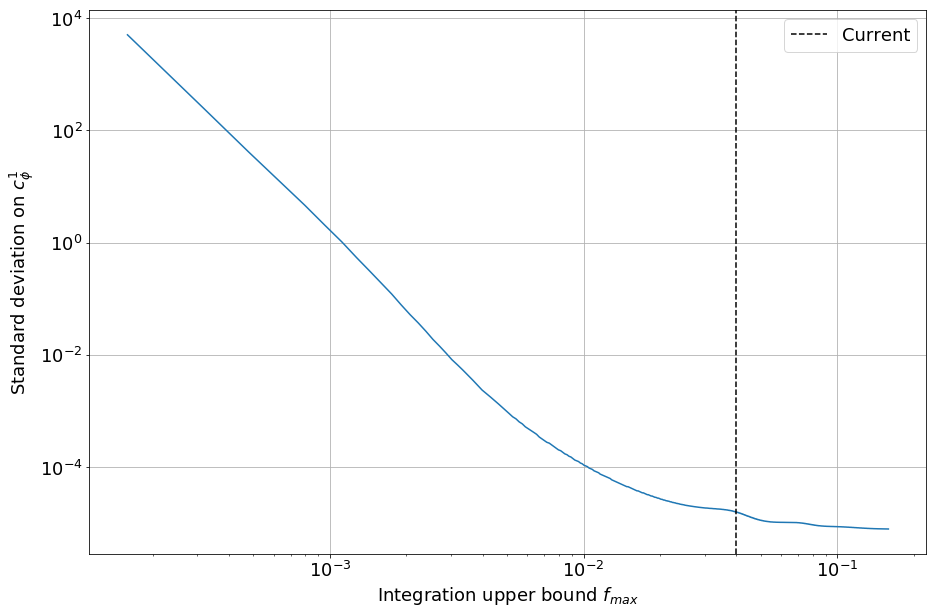

In [15]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

wmax_vec = np.linspace(0, 1, 1000)
sigma_c1_vec = []

for i in range(len(wmax_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin, wmax_vec[i], 'no plot')
    sigma_c1_vec.append(covX_matrix[0][0]**0.5) # getting bounds on one coefficient
    
fig = plt.figure(figsize=(15, 10))
plt.loglog(wmax_vec/(2*np.pi), sigma_c1_vec)
plt.ylabel('Standard deviation on $c_{\\phi}^1$')
plt.xlabel('Integration upper bound $f_{max}$')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k', label='Current')
plt.legend()
plt.grid()

print 'f_min = ', wmin/(2*np.pi) 

/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in divide
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


f_max =  0.04


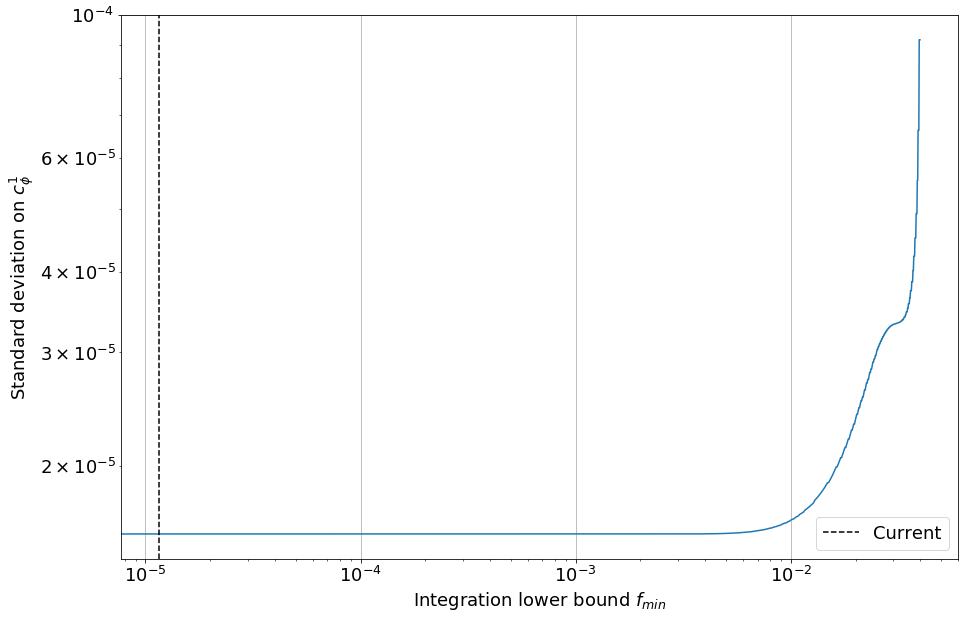

In [16]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

wmin_vec = np.linspace(0, 1, 1000)
sigma_c1_vec = []

for i in range(len(wmax_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin_vec[i], wmax, 'no plot')
    sigma_c1_vec.append(covX_matrix[0][0]**0.5) # getting bounds on one coefficient
    
fig = plt.figure(figsize=(15, 10))
plt.loglog(wmax_vec/(2*np.pi), sigma_c1_vec)
plt.ylabel('Standard deviation on $c_{\\phi}^1$')
plt.xlabel('Integration lower bound $f_{min}$')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k', label='Current')
plt.legend()
plt.grid()

print 'f_max = ', wmax/(2*np.pi) 

In [18]:
## Changing both bounds to see if we can minimize the standard deviation on TTL coefficient c1

from matplotlib.colors import LogNorm

N_contour = 100
wmax_vec = np.linspace(0, 1, N_contour)
wmin_vec = np.linspace(0, 1, N_contour)
Wmax, Wmin = np.meshgrid(wmax_vec, wmin_vec)
sigma11 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma22 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma33 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma44 = np.zeros((len(wmax_vec), len(wmax_vec)))

for i in range(N_contour):
    for j in range(N_contour):
        if Wmax[i,j] < Wmin[i,j]:
            covX_matrix = covX(dur, tau, dt, fs, N, Wmax[i,j], Wmin[i,j], 'no plot')
            sigma11[i,j]  = covX_matrix[0][0]**0.5
            sigma22[i,j]  = covX_matrix[1][1]**0.5
            sigma33[i,j]  = covX_matrix[2][2]**0.5
            sigma44[i,j]  = covX_matrix[3][3]**0.5
        else:
            sigma11[i,j]  = 0
            sigma22[i,j]  = 0
            sigma33[i,j]  = 0
            sigma44[i,j]  = 0

/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in divide


/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


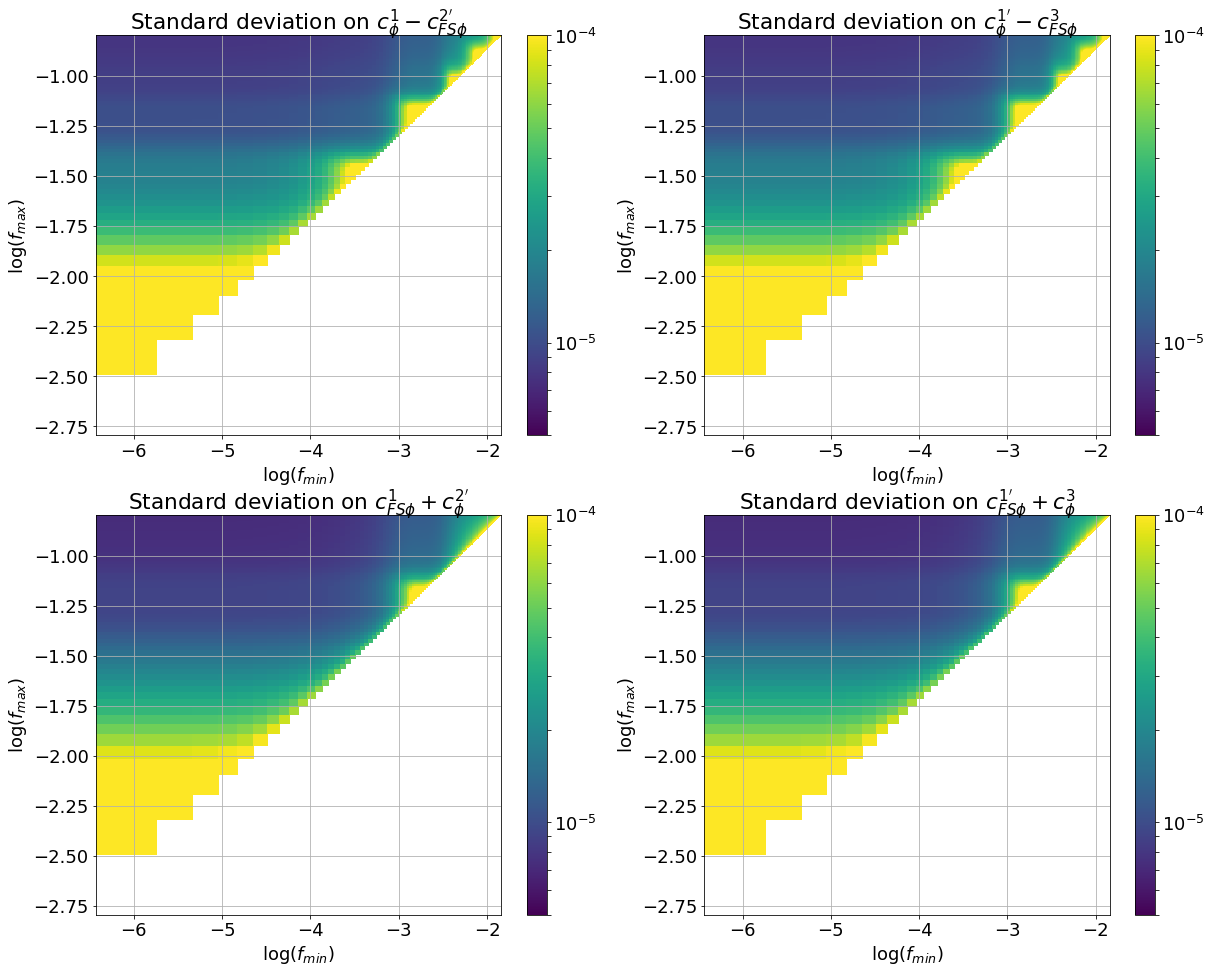

In [33]:
## Plotting contours for sigma

sigmas  = [sigma11, sigma22, sigma33, sigma44]
ylabels = ['c_{\\phi}^1 - c_{FS\\phi}^{2^{\prime}}', 'c_{\\phi}^{1^{\prime}} - c_{FS\\phi}^{3}}', 'c_{FS\\phi}^{1} + c_{\\phi}^{2^{\prime}}', 'c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}']

fig= plt.figure(figsize=(20, 25))
for i in range(4):
    i += 1
    plt.subplot('32%s' %i)
    i -= 1
    plt.title('Standard deviation on $%s$' %ylabels[i])
    #c11 = plt.pcolor(Wmax/(2*np.pi), Wmin/(2*np.pi), sigma11, norm=LogNorm(vmin=.5e-5, vmax=1e-4))
    c11 = plt.pcolor(np.log(Wmax/(2*np.pi)), np.log10(Wmin/(2*np.pi)), sigmas[i], norm=LogNorm(vmin=.5e-5, vmax=1e-4))
    plt.colorbar(c11)
    plt.xlabel('log($f_{min}$)')
    plt.ylabel('log($f_{max}$)')
    plt.grid()


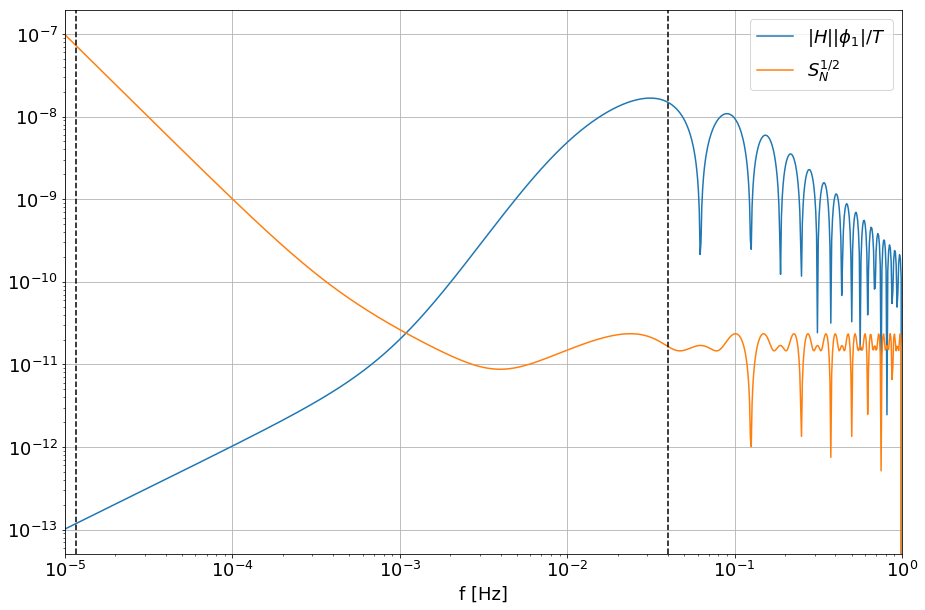

In [20]:
# Plotting integrand components individually

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, ((phi1_modsq/dur)**0.5)*H_modsq**0.5, label='$|H||\phi_1|/T$')
plt.loglog(freq, S_N**0.5, label='$S_N^{1/2}$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid()

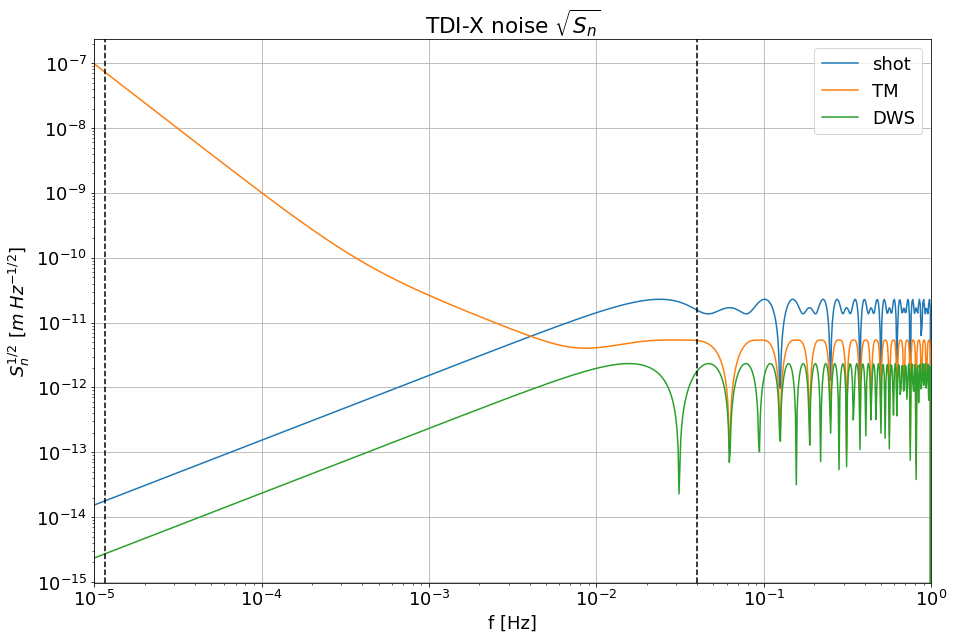

In [21]:
# Plotting various noise curves

freq = np.logspace(-5, 0, 1000)
w    = 2*np.pi*freq

# Shot-noise
n1_psd  = (6e-12)**2
n2p_psd = (6e-12)**2

S_n_shot_x = 2.*(2*n1_psd*(1-cos(2*w*tau)) + (2*n2p_psd)*(1-cos(3*w*tau)))
S_n_shot   = n1_psd*np.ones(1000)

# TM-motion PSD
delta1_psd  = (2.4e-15)**2
delta2p_psd = (2.4e-15)**2
    
S_n_delta_x  = 2*(2*delta1_psd*(1-cos(4*w*tau)) + 8*delta2p_psd*(1-cos(2*w*tau)))
S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise

S_delta = delta1_psd
S_delta *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise

# DWS noise PSD
c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
n_phi1_psd = n_phi1p_psd = n_phi2p_psd = n_phi3_psd = ((35e-9)/300.)**2

S_n_phi_x  = n_phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau))
S_n_phi_x += n_phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau))
S_n_phi_x += n_phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS*cos(2*w*tau))
S_n_phi_x += n_phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS*cos(2*w*tau))
S_n_phi_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn

S_n = S_n_shot_x + S_n_delta_x + S_n_phi_x

fig = plt.figure(figsize=(15, 10))
plt.title('TDI-X noise $\\sqrt{S_n}$')
plt.loglog(freq, S_n_shot_x**0.5, label='shot')
#plt.loglog(freq, S_n_shot**0.5, label='shot without TDI')
plt.loglog(freq, S_n_delta_x**0.5, label='TM')
#plt.loglog(freq, S_delta**0.5, label='TM without TDI')
#plt.loglog(freq, S_n**0.5, label='TM + shot')
plt.loglog(freq, S_n_phi_x**0.5, label='DWS')
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
#plt.axvline(x=3e-3, ls='--', c='k')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid()

In [160]:
# integral bounds test

freq = np.logspace(-5, 0, 10)
w    = 2*np.pi*freq

w_max_idx = find_nearest(w, wmax)
#print w_max_idx, wmax, w
w = w[:w_max_idx+1]
#print w

wmin = 2.25805972e-04
w_min_idx = find_nearest(w, wmin)
print w_min_idx, wmin, w
w = w[w_min_idx:]
print w

1 0.000225805972 [6.28318531e-05 2.25805972e-04 8.11504588e-04 2.91639628e-03
 1.04809848e-02 3.76667063e-02 1.35367124e-01]
[0.00022581 0.0008115  0.0029164  0.01048098 0.03766671 0.13536712]


/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/danielgeorge/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


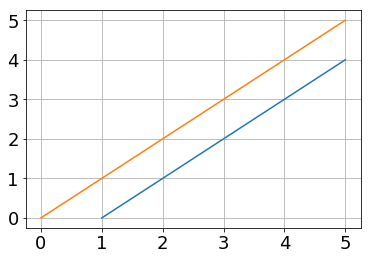

In [32]:
# Testing log fns

x = [0, 1, 2, 3, 4, 5]
y = [0, 1, 10, 100, 1000, 10000]
z = np.log(y)
a = np.log10(y)

#plt.plot(x, z)
plt.plot(x, a)
plt.plot(x, x)
plt.grid()